In [1]:
import pyccl as ccl
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
import subprocess
import zipfile
import pandas as pd
from scipy.integrate import odeint
from scipy.signal import savgol_filter
from configobj import ConfigObj

from os.path import basename
#from HiCOLA import Frontend

In [2]:
def find_idxnearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return np.int(idx)

def wr_funct(T_CMB):
    return 4.48150052e-7*T_CMB**4 *(1+ 3.044*7/8 * (4/11)**(4/3))

T_CMB = 2.72548 # K.split(',')

# Look at phase pair

In [3]:
''' Define useful functions'''

def create_params(f, E, h, omegas):
    '''
    Get parameters k, g from f, E and cosmo
    Inputs:
    f --> fphi
    E --> EdS
    omegas --> [b, c, r] * h^2
    
    Outputs:
    k --> k1dS
    g --> g31dS
    '''
    
    # cosmological constant density
    o_DE = h**2 - omegas[0] - omegas[1] - omegas[2]
    O_L = (1-f)*o_DE/ h**2
    
    # k and g
    alpha = 1 - O_L/E**2
    k = -6*alpha
    g = 2*alpha
    
    return k, g

def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    h = 0.67
    wb = 0.0223
    wr = 4.28e-5
    
    hcube = np.loadtxt(txt).T
    wm = hcube[0]
    n_s = hcube[1]
    A_s = hcube[2]
    E_dS = hcube[3]
    f_phi = hcube[4]
    k1 , g31 = create_params(f_phi, E_dS, h, [wb,wm - wb,wr])
    arr_hor = [f_phi, 1/E_dS, k1, g31]
    arr_num = [h*np.ones(len(wm)), wr*np.ones(len(wm)), wb*np.ones(len(wm)), wm - wb, n_s, A_s]
    
    return arr_hor, arr_num

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

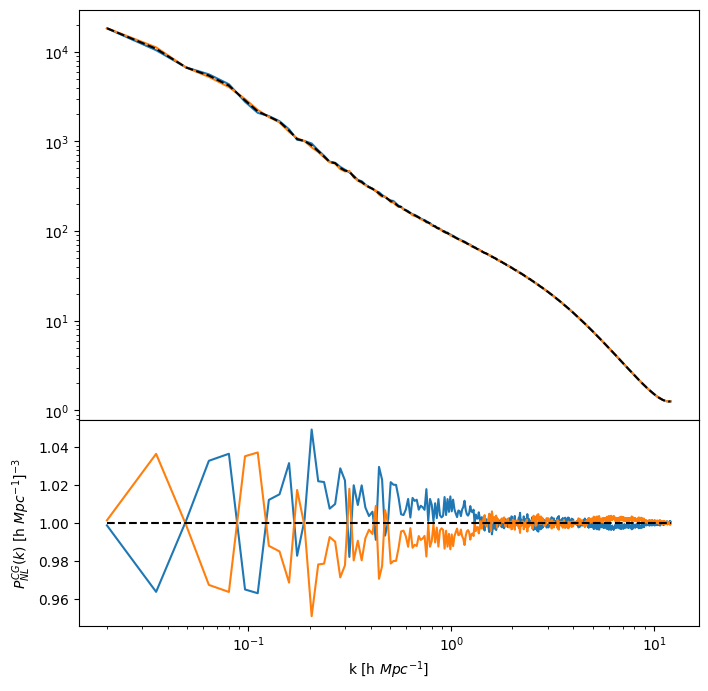

In [4]:
"""Plotting phase pair z = 0"""

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8),height_ratios=[2,1])
fig.subplots_adjust(hspace=0,wspace=0)

for i in range(1):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    ax[0].plot(k,Pk_NL)
    ax[0].plot(k,Pk_NL_pp)
    ax[0].plot(k,(Pk_NL+ Pk_NL_pp)/2, "k--")

    ax[1].plot(k,Pk_NL/((Pk_NL+ Pk_NL_pp)/2))
    ax[1].plot(k,Pk_NL_pp/((Pk_NL+ Pk_NL_pp)/2))
    ax[1].plot(k,(Pk_NL+ Pk_NL_pp)/2/((Pk_NL+ Pk_NL_pp)/2), "k--")

ax[0].set_xscale("log")
ax[0].set_yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

# Account for different growth at z=49 (initial conditions)

## From the gravity model file

In [6]:
sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation').T
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation'
a_n = hypercube_arrays(txt)
cmap = matplotlib.colormaps['viridis']

In [7]:
def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    hcube = np.loadtxt(txt).T

    wb = 0.0223*np.ones(len(hcube[0]))
    wr = wr_funct(T_CMB)*np.ones(len(hcube[0]))
    
    n_s = hcube[1]
    A_s = hcube[2]
    h = hcube[3]
    wm = hcube[0]*h**2


    arr_num = [h, wr, wb, wm - wb, n_s, A_s]
    
    return arr_num



In [9]:
gravitymodel_kp00001 = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_24_tracker/gravitymodel_my_new_Hi-COLA_simulation_24_tracker_k0.00001.txt')
gravitymodel_k10 = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_24_tracker/gravitymodel_my_new_Hi-COLA_simulation_24_tracker_k10.0.txt')

gravitymodel_kp00001_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_24_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_24_GR_tracker_k0.00001.txt')
gravitymodel_k10_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_24_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_24_GR_tracker_k10.0.txt')

print(gravitymodel_kp00001.shape)

(200, 11)


Text(0.5, 0, 'z')

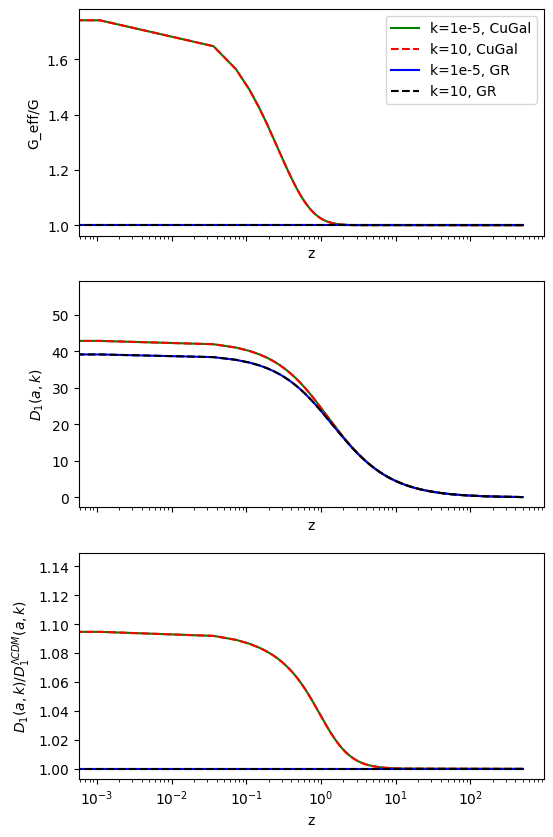

In [10]:
f, ax = plt.subplots(3,1, sharex=True, sharey=False,figsize=(6, 10))

z_array = 1/gravitymodel_k10_GR.T[0] - 1

ax[0].semilogx(z_array, gravitymodel_kp00001.T[1], "g", label="k=1e-5, CuGal")
ax[0].semilogx(z_array, gravitymodel_k10.T[1], "r--", label="k=10, CuGal")
ax[0].semilogx(z_array, gravitymodel_kp00001_GR.T[1], "b", label="k=1e-5, GR")
ax[0].semilogx(z_array, gravitymodel_k10_GR.T[1], "k--", label="k=10, GR")

ax[0].set_ylabel("G_eff/G")
ax[0].set_xlabel("z")
ax[0].legend()

ax[1].semilogx(z_array, gravitymodel_kp00001.T[2], "g", label="k=1e-5, CuGal")
ax[1].semilogx(z_array, gravitymodel_k10.T[2], "r--", label="k=10, CuGal")
ax[1].semilogx(z_array, gravitymodel_kp00001_GR.T[2], "b", label="k=1e-5, GR")
ax[1].semilogx(z_array, gravitymodel_k10_GR.T[2], "k--", label="k=10, GR")

z_49 = z_array[find_idxnearest(z_array, 499)]

#ax[1].semilogx([z_49,z_49], [0,40], "k--")
#ax[1].semilogx([z_array[0],z_array[0]], [0,40], "k--")

ax[1].set_ylabel(r"$D_1(a,k)$")
ax[1].set_xlabel("z")
#ax[1].legend()

ax[2].semilogx(z_array, gravitymodel_kp00001.T[2]/gravitymodel_kp00001_GR.T[2], "g", label="k=1e-5, CuGal")
ax[2].semilogx(z_array, gravitymodel_k10.T[2]/gravitymodel_k10_GR.T[2], "r--", label="k=10, CuGal")
ax[2].semilogx(z_array, gravitymodel_kp00001_GR.T[2]/gravitymodel_kp00001_GR.T[2], "b", label="k=1e-5, GR")
ax[2].semilogx(z_array, gravitymodel_k10_GR.T[2]/gravitymodel_k10_GR.T[2], "k--", label="k=10, GR")

ax[2].set_ylabel(r"$D_1(a,k)/D_1^{\Lambda CDM}(a,k)$")
ax[2].set_xlabel("z")

23
24


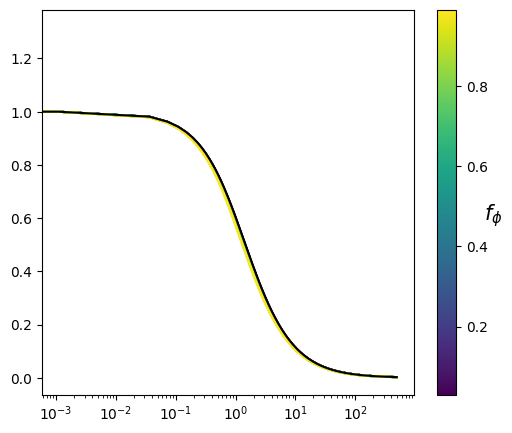

In [14]:
f, ax = plt.subplots(1,1, sharex=True, sharey=False,figsize=(6, 5))

theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
cbar = f.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)


for i in range(25):
    
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T
    ax.semilogx(z_array, gravitymodel[2]/gravitymodel[2][find_idxnearest(z_array, 0)], label="CuGal",  color = cmap(frac0[i]))

ax.semilogx(z_array, gravitymodel_GR[2]/gravitymodel_GR[2][find_idxnearest(z_array, 0)],"k", label="GR")

#print(gravitymodel[2]/gravitymodel[2][-1])
#print(z_array)

23
24


Text(0.5, 0, 'a')

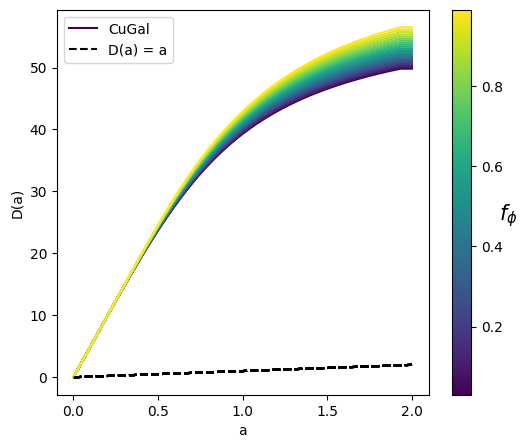

In [15]:
f, ax = plt.subplots(1,1, sharex=True, sharey=False,figsize=(6, 5))

theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cbar = f.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)


for i in range(25):
    
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T
    ax.plot(1/(z_array+1), gravitymodel[2],  color = cmap(frac0[i]))
    ax.plot(1/(z_array+1),1/(z_array+1), "k--")

plt.legend(["CuGal" , "D(a) = a"])

ax.set_ylabel("D(a)")
ax.set_xlabel("a")
#print(gravitymodel[2]/gravitymodel[2][-1])
#print(z_array)

23
24


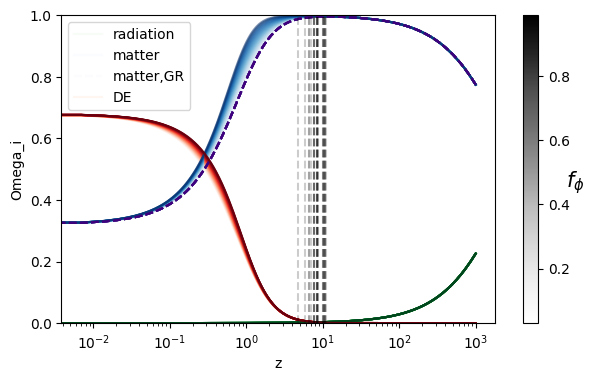

In [16]:
## Plotting ##

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

z_matterdom = []
z_matterdom_gr = []

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(25):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(sample_new[0][i])
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    cmap = matplotlib.colormaps['Greens']
    ax.plot(1/a_today -1, wr*a_today**(-4)/E_a_today**2/h**2, alpha=0.9, color = cmap(frac0[i]))
    cmap = matplotlib.colormaps['Blues']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_today**2/h**2, alpha=0.5, color = cmap(frac0[i]))

    cmap = matplotlib.colormaps['Purples']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_GR**2/h**2, alpha=1,linestyle="--", color = cmap(frac0[i]))
    
    cmap = matplotlib.colormaps['Reds']
    ax.plot(1/a_today -1, ((h**2 - wm -wr)/E_a_today**2)/h**2, alpha=0.9, color=cmap(frac0[i]))

    z_matterdom.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)])
    z_matterdom_gr.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)])

ax.plot([z_matterdom,z_matterdom], [0,1], "k--", alpha=0.2)

ax.set_xlabel("z")

ax.legend(["radiation", "matter", "matter,GR", "DE"])
ax.set_ylabel(r"Omega_i")
ax.set_xscale("log")
ax.set_ylim(0,1.0)
theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cmap = matplotlib.colormaps['Greys']

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)




Text(0, 0.5, '$D^{CuGal}(z)$')

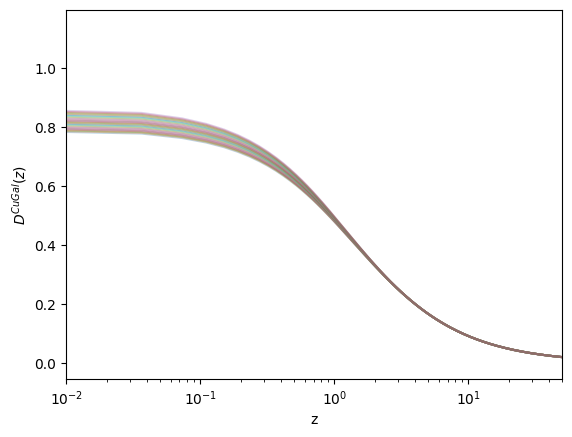

In [17]:
for i in range(25):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T

    plt.plot(z_array, gravitymodel[2] / (CubicSpline(1/(z_array+1), gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1))) , alpha=0.3)

#plt.legend(["CuGal", "LCDM"])
plt.xlabel("z")
plt.xscale("log")
plt.xlim(1e-2,50)
plt.ylabel(r"$D^{CuGal}(z)$")



Text(0, 0.5, '$D^{CuGal}(z)/D^{LCDM}(z)$')

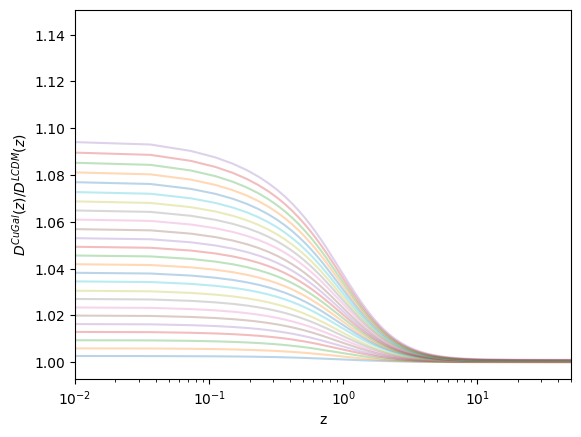

In [18]:
for i in range(25):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T

    plt.plot(z_array, gravitymodel[2] / (CubicSpline(1/(z_array+1), gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1))) /
             (gravitymodel_GR[2] / (CubicSpline(1/(z_array+1), gravitymodel_GR[2])(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1)))), alpha=0.3)

#plt.legend(["CuGal", "LCDM"])
plt.xlabel("z")
plt.xscale("log")
plt.xlim(1e-2,50)
plt.ylabel(r"$D^{CuGal}(z)/D^{LCDM}(z)$")



Text(0, 0.5, '$D(z)$')

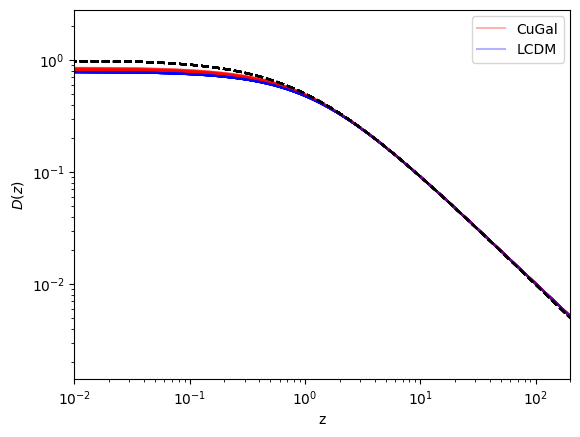

In [19]:
for i in range(25):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T


    plt.plot(z_array, gravitymodel[2] / (CubicSpline(1/(z_array+1),gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1))) ,"r", alpha=0.3)

    plt.plot(z_array, gravitymodel_GR[2] / (CubicSpline(1/(z_array+1),gravitymodel_GR[2])(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1))) ,"b", alpha=0.3)
    plt.plot(z_array, 1/(z_array+1), "k--")

plt.legend(["CuGal", "LCDM"])
plt.xlabel("z")
plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2,200)
plt.ylabel(r"$D(z)$")



In [20]:
ratio_growth = []
for i in range(25):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T
    
    D_a_norm = gravitymodel[2] / (CubicSpline(1/(z_array+1),gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1)))

    D_a_norm_GR = gravitymodel_GR[2] / (CubicSpline(1/(z_array+1),gravitymodel_GR[2])(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1)))
    
    
    # We have D_norm(a) = D_(a) * D(a_matterdom)/a - below we ignore the a factor because it is the same in both
    ratio_growth.append(D_a_norm[find_idxnearest(z_array, 49)]/D_a_norm_GR[find_idxnearest(z_array, 49)])



/tmp/ipykernel_1368965/84250641.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


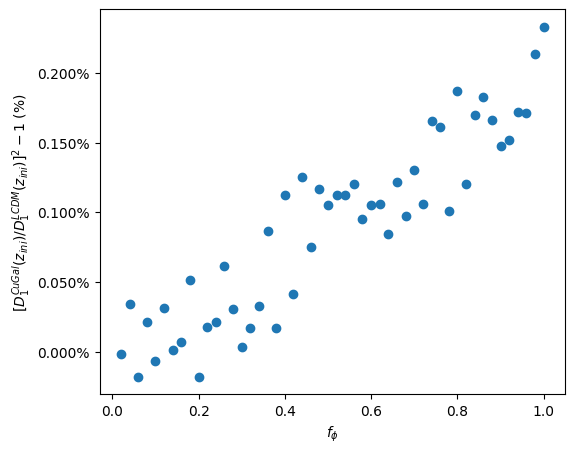

In [31]:
f_phi = sample_new[-1]
f, ax = plt.subplots(1,1, sharex=True, sharey=False,figsize=(6, 5))


ax.scatter(f_phi, (np.array(ratio_growth)**2 - 1))
ax.set_ylabel(r"$[D_1^{CuGal}(z_{ini})/D_1^{LCDM}(z_{ini})]^2 -1$ (%)")
ax.set_xlabel(r"$f_\phi$")

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


plt.show()

## From the frontend files (LH, final)

### Get expansion and force files

In [5]:
"""Define tracker functions"""

# If we are on the tracker, we will get the following constraints equations

# For today formalism 
def k_1T(Omg_m, Omg_r, f_phi):
    return 6*f_phi*(Omg_m + Omg_r - 1)

# dS formalism

def E_dS(Omg_m, Omg_r, f_phi):

    return np.sqrt((1-f_phi)*(1-Omg_m-Omg_r)/2 + np.sqrt(
        ((1-f_phi)*(1-Omg_m-Omg_r)/2)**2 + f_phi*(1-Omg_m-Omg_r)
    ))

In [6]:
''' Define useful functions'''

def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    hcube = np.loadtxt(txt).T

    wb = 0.0223*np.ones(len(hcube[0]))
    wr = wr_funct(T_CMB)*np.ones(len(hcube[0]))
    
    n_s = hcube[1]
    A_s = hcube[2]
    h = hcube[3]
    wm = hcube[0]*h**2


    arr_num = [h, wr, wb, wm - wb, n_s, A_s]
    
    return arr_num

def Update_ini(run, f_phi, arr_num, horn_ini, num_ini):
    """
    Updates files num_ini and horn_ini to include the parameters (numerical and MG) from 
    f_phi and
    arr_num = h , wr , wb , wc, n_s , A_s
    """
    ## Horndeski params
    h , wr , wb , wc, n_s , A_s = arr_num
    config_h = ConfigObj(horn_ini)

    f_phi = 0.0
    k1_track = k_1T((wc + wb)/h**2, wr/h**2, f_phi)

    keys_h = config_h.keys()
    
    config_h[keys_h[1]] = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges'
    config_h[keys_h[0]] = 'horndeski_model'
    
    config_h[keys_h[2]] = 'k_1*X'
    config_h[keys_h[3]] = 'g_31*X'
    config_h[keys_h[4]] = '0.5'

    config_h[keys_h[7]] = str(k1_track)
    config_h[keys_h[8]] = str("1")
    config_h[keys_h[9]] = str(f_phi)
    config_h[keys_h[10]] = str("1")
    config_h[keys_h[11]] = str("1")
    config_h[keys_h[20]] = str("False")
    config_h[keys_h[22]] = str("1")
    
    ## Numerical params
    config_n = ConfigObj(num_ini)
    keys_n = config_n.keys()
    
    config_n[keys_n[0]] = 'run_'+str(run)

    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_h.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini'
    config_n.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    config_h.write(); config_n.write()

In [7]:
"""!!!!! CAREFUL WHEN RUNNING THIS deletes a whole directory of frontend parameter files"""
### Run frontend for all different .ini files

#command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/'
#os.system(command)
#command = 'cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/; mkdir Output'
#os.system(command)
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation_edges'

a_n = hypercube_arrays(txt)
for i in range(len(np.array(a_n).T)):
    #Update_ini(str(i), 0.0, np.array(a_n).T[i], '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_parameters.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_parameters.ini')
    #command = 'cd; source HiCOLA_env/3.7.12/bin/activate; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    #subprocess.run(['bash', '-c', command])
    print()
    

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2825813719309296
Omega_r0 = 0.0001122237184887728
Omega_lambda0 = 0.7173064043505817
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_0_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gro

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.28379085072620075
Omega_r0 = 0.00011239625807654914
Omega_lambda0 = 0.7160967530157226
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_1_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2754784328241553
Omega_r0 = 7.970764637831775e-05
Omega_lambda0 = 0.7244418595294664
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_2_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gro

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27488468868829496
Omega_r0 = 7.915348877160016e-05
Omega_lambda0 = 0.7250361578229334
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_3_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27499464130604684
Omega_r0 = 0.0001081501957664443
Omega_lambda0 = 0.7248972084981866
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_4_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.28442857590916193
Omega_r0 = 0.00010850978471223753
Omega_lambda0 = 0.7154629143061259
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_5_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27631407271906994
Omega_r0 = 7.869609342740268e-05
Omega_lambda0 = 0.7236072311875027
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_6_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2782272482679534
Omega_r0 = 8.159748123283407e-05
Omega_lambda0 = 0.7216911542508138
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_7_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.28093208266465075
Omega_r0 = 0.00011162294828244084
Omega_lambda0 = 0.7189562943870668
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -6.617444900424222e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_8_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2799425091048834
Omega_r0 = 0.00011237898621827161
Omega_lambda0 = 0.7199451119088983
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -6.617444900424222e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_9_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27785340936759684
Omega_r0 = 8.243734321807669e-05
Omega_lambda0 = 0.722064153289185
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_10_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2850882916156734
Omega_r0 = 8.064426069657229e-05
Omega_lambda0 = 0.7148310641236301
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_11_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2794807081103253
Omega_r0 = 0.00010777616968837998
Omega_lambda0 = 0.7204115157199863
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_12_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.28145985522985995
Omega_r0 = 0.00010429450621211768
Omega_lambda0 = 0.718435850263928
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_13_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2775015609907907
Omega_r0 = 7.904131347837511e-05
Omega_lambda0 = 0.7224193976957309
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_14_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2749286697353957
Omega_r0 = 7.876698301228638e-05
Omega_lambda0 = 0.7249925632815921
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_15_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3240060206689667
Omega_r0 = 0.00010949964734426113
Omega_lambda0 = 0.6758844796836889
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_16_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3294376799859118
Omega_r0 = 0.00011213759764371605
Omega_lambda0 = 0.6704501824164445
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_17_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3299434620275707
Omega_r0 = 8.274199733391565e-05
Omega_lambda0 = 0.6699737959750953
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_18_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3309330355873379
Omega_r0 = 7.851424475087162e-05
Omega_lambda0 = 0.6689884501679112
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_19_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.330823082969586
Omega_r0 = 0.00010918473040136326
Omega_lambda0 = 0.6690677323000127
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230411687688e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_20_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3303612819750279
Omega_r0 = 0.00011177697045551458
Omega_lambda0 = 0.6695269410545166
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_21_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3311529408228418
Omega_r0 = 8.338950096919424e-05
Omega_lambda0 = 0.668763669676189
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 3.032693018334745e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_22_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Grow

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.33016336726307444
Omega_r0 = 7.940932241587149e-05
Omega_lambda0 = 0.6697572234145097
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230411687688e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_23_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3288439358500514
Omega_r0 = 0.0001069857736748945
Omega_lambda0 = 0.6710490783762737
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_24_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3273925612957259
Omega_r0 = 0.00010979924817617277
Omega_lambda0 = 0.6724976394560979
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_25_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32558933836459447
Omega_r0 = 7.927613438426186e-05
Omega_lambda0 = 0.6743313855010212
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_26_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3291518031797568
Omega_r0 = 8.214516034511297e-05
Omega_lambda0 = 0.6707660516598981
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_27_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3228405229207964
Omega_r0 = 0.00010524277747640905
Omega_lambda0 = 0.6770542343017272
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_28_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.33069113982828363
Omega_r0 = 0.00011008333498197347
Omega_lambda0 = 0.6691987768367343
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102229860355025e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_29_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3269747413482686
Omega_r0 = 7.854450906355455e-05
Omega_lambda0 = 0.6729467141426678
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102229860355025e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_30_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32024564114185095
Omega_r0 = 7.955313139408055e-05
Omega_lambda0 = 0.679674805726755
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_31_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32927571939373085
Omega_r0 = 8.753891972978207e-05
Omega_lambda0 = 0.6706367416865394
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 3.032693018334745e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_32_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Gr

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32976129663234177
Omega_r0 = 9.392804489302911e-05
Omega_lambda0 = 0.6701447753227652
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_33_expansion_1.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/G

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Frontend/generate_simulation_input.py", line 69, in <module>
    lambdified_functions = eb.create_Horndeski(K,G3,G4,symbol_list,mass_ratio_list)
  File "/home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Frontend/expression_builder.py", line 996, in create_Horndeski
    E_prime_E = EprimeEODERHS(G3, G4, K, M_pG4=M_pG4_test, M_KG4=M_KG4_test, M_G3s=M_G3s_test, M_sG4=M_sG4_test,M_G3G4=M_G3G4_test,M_Ks=M_Ks_test) #These are the actual equations that need to use SymPy builder script
  File "/home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/Frontend/expression_builder.py", line 292, in EprimeEODERHS
    EprimeE =  sym.simplify((term2 + term3 + term4)/sym.simplify(term1))
  File "/home/c2042999/HiCOLA_env/3.7.12/lib/python3

### Get the growth ratio

28
29


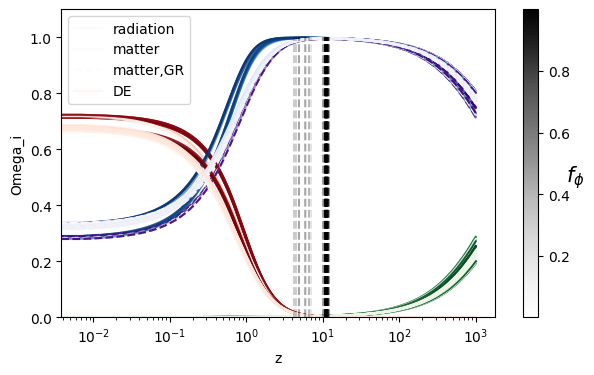

In [8]:
## Plotting ##

sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation_edges').T
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_validation_edges'
a_n = hypercube_arrays(txt)
cmap = matplotlib.colormaps['viridis']

f_phi = sample_new[-1]

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

z_matterdom = []
z_matterdom_gr = []
theta = f_phi
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation_edges/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]

    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(wm/h**2)
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation_edges/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    cmap = matplotlib.colormaps['Greens']
    ax.plot(1/a_today -1, wr*a_today**(-4)/E_a_today**2/h**2, alpha=0.9, color = cmap(frac0[i]))
    cmap = matplotlib.colormaps['Blues']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_today**2/h**2, alpha=0.5, color = cmap(frac0[i]))

    cmap = matplotlib.colormaps['Purples']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_GR**2/h**2, alpha=1,linestyle="--", color = cmap(frac0[i]))
    
    cmap = matplotlib.colormaps['Reds']
    ax.plot(1/a_today -1, ((h**2 - wm -wr)/E_a_today**2)/h**2, alpha=0.9, color=cmap(frac0[i]))

    z_matterdom.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)])
    z_matterdom_gr.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)])

ax.plot([z_matterdom,z_matterdom], [0,1], "k--", alpha=0.1)
ax.plot([z_matterdom_gr,z_matterdom_gr], [0,1], "k--", alpha=0.1)

ax.set_xlabel("z")

ax.legend(["radiation", "matter", "matter,GR", "DE"])
ax.set_ylabel(r"Omega_i")
ax.set_xscale("log")
ax.set_ylim(0,1.1)

print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cmap = matplotlib.colormaps['Greys']

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)




In [9]:
def solverGrowth_mu(y,a,a_arr, mu_arr,E_arr,Omega_m):
    mu = CubicSpline(a_arr,mu_arr)(a)
    E_val = CubicSpline(a_arr,E_arr)(a)

    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D*mu/(2*E_val*a**2)]
    return ydot


0.000999
1.0
0.000999


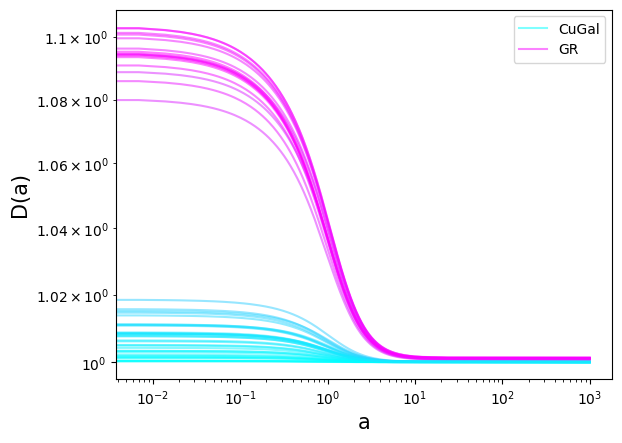

In [10]:
############### NEW VERSION ##################

cmap = matplotlib.colormaps['cool']

ratio_growth_new = []

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

print(a_today[0])
print(a_today[-1])
print(np.min(a_today))


###############################################
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation_edges/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    expansion_today_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR_validation_edges/horndeski_model_run_{}_expansion.txt".format(i))
    E_a_GR = expansion_today_GR.T[1]

    E_a_today = expansion_today.T[1]
    E_a_GR_analytic = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h
    E_a_today = savgol_filter(E_a_today/E_a_GR,100, 3) * E_a_GR_analytic

    idx_matterdom = np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)
    idx_matterdom_gr = np.argmax(wm*a_today**(-3)/E_a_GR_analytic**2/h**2)

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output_validation_edges/horndeski_model_run_{}_force.txt".format(i))

    coupling = force_today.T[2]
    mu = (coupling + 1)
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_a_today[0]*a_today[0]**3)], a_today, \
                  args=(a_today, mu,E_a_today,wm/h**2), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_a_GR_analytic[0]*a_today[0]**3)], a_today,\
                  args=(a_today, np.ones(len(a_today)),E_a_GR_analytic,wm/h**2), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    D_a_norm = Delta / ((CubicSpline(a_today,Delta)(a_today[idx_matterdom])) / a_today[idx_matterdom])

    D_a_norm_GR = Delta_GR / ((CubicSpline(a_today,Delta_GR)(a_today[idx_matterdom_gr])) / a_today[idx_matterdom_gr])
    
    plt.semilogx(1/a_today - 1, D_a_norm/D_a_norm_GR, alpha= 0.5, color = cmap(frac0[i]))

    ratio_growth_new.append(D_a_norm/D_a_norm_GR)
    #ratio_growth_new.append(D_a_norm[find_idxnearest(a_today, 0.02)]/D_a_norm_GR[find_idxnearest(a_today, 0.02)])

plt.xlabel("a", fontsize=15)
plt.ylabel("D(a)", fontsize=15)
plt.legend(["CuGal", "GR"])
#plt.xlim(1e-3,1e-2)
#plt.ylim(1e-3,3e-2)
plt.yscale("log")

/tmp/ipykernel_1175253/1538221208.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


Text(0, 0.5, '$z_i=49$')

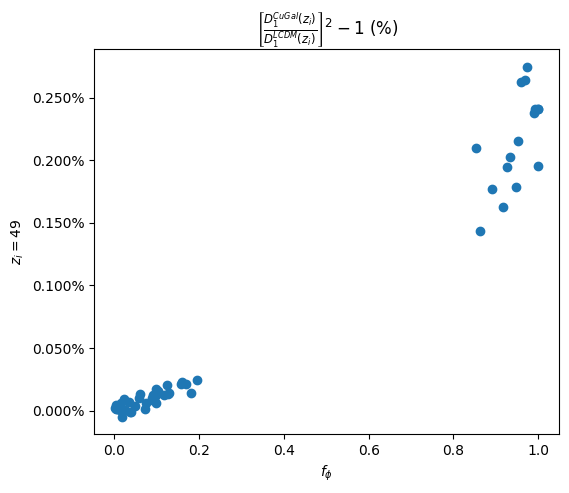

In [11]:
f, ax = plt.subplots(1,1, figsize=(6, 5), sharex=True)
fig.subplots_adjust(wspace=0)
idx = np.argmin(np.abs(a_today - 0.02))


ax.set_title(r"$\left[\frac{D_1^{CuGal}(z_i)}{D_1^{LCDM}(z_i)}\right]^2 - 1$ (%)")
ax.set_xlabel(r"$f_\phi$")

idx = np.argmin(np.abs(a_today - 0.02))
ax.scatter(f_phi, (np.array(ratio_growth_new).T[idx]**2 ) - 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax.set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))


In [12]:
print((np.array(ratio_growth_new).T[idx][np.argmax(np.array(ratio_growth_new).T[idx])])**2 - 1)

0.002744521467284766


# Create P(k) files

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

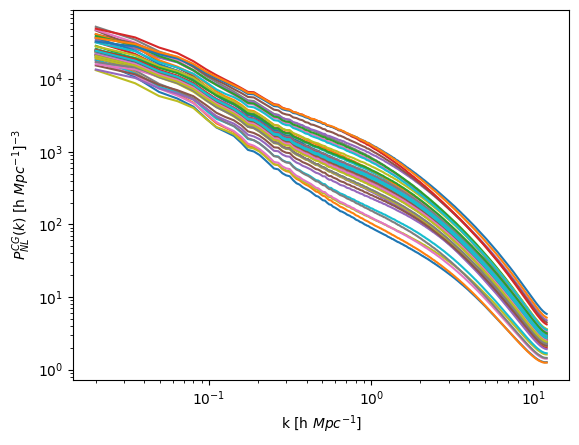

In [18]:
"""Plotting the NL power spectra for the simulations at z = 0, CG"""

for i in range(len(a_n[0])):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    plt.plot(k,(Pk_NL+ Pk_NL_pp)/2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

Text(0, 0.5, '$P^{GR}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

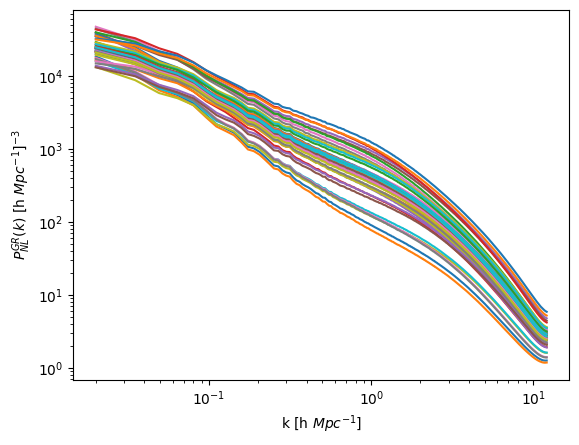

In [17]:
"""Plotting the NL power spectra for the simulations at z = 0, GR"""

for i in range(len(a_n[0])):
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    plt.plot(k,(Pk_NL_GR+ Pk_NL_GR_pp)/2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{GR}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

Text(0, 0.5, '$B(k, z=0)$')

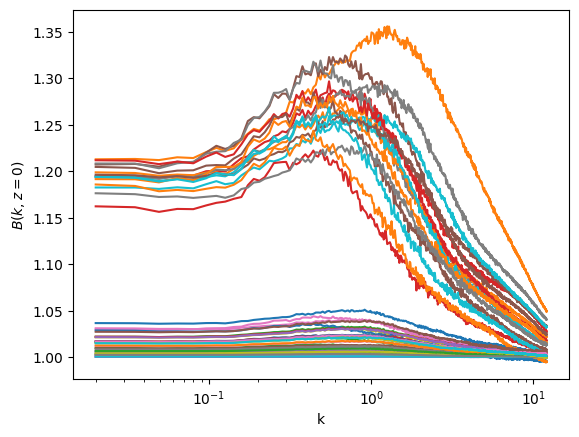

In [19]:
"""Plotting the Boost for the simulations at z = 0"""

for i in range(len(a_n[0])):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    Boost = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp))
        
    plt.plot(k,Boost)
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z=0)$")

In [16]:
"""Example for a single point of how to get out P(k) at different z"""
for i in range(1):
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}*'.format(i,i), recursive=True):
        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        if c == 0:
            Pk_NL = [Pk_NL_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
        else:
            Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    """
    print(sorted(z))
    print(Pk_NL[:,0].shape)
    plt.plot(sorted(z),Pk_NL[z.argsort()][:,10], "b")
    plt.scatter(z,Pk_NL[:,10])
    print(Pk_NL[z.argsort()])
    print(z)
    # to check that sorting method for Pk_NL works
    """


In [21]:
"""By the end of this cell, will have 
Boost = Boost(simulation, z, k)  --- WITH GROWTH FACTOR NORMALIZATION INCLUDED!
k = wavevector
z = redshift"""

Boost = np.zeros((len(a_n[0]),101,768))

for i in range(len(a_n[0])):

    # CG, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_NL = [Pk_NL_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL = Pk_NL[z.argsort()]

    # CG, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_NL_pp = [Pk_NL_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL_pp = np.append(Pk_NL_pp, [Pk_NL_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL_pp = Pk_NL_pp[z.argsort()]
    
    # GR, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_NL_GR = [Pk_NL_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL_GR = Pk_NL_GR[z.argsort()]

    # GR, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_NL_GR_pp = [Pk_NL_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL_GR_pp = np.append(Pk_NL_GR_pp, [Pk_NL_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL_GR_pp = Pk_NL_GR_pp[z.argsort()]

    Boost[i] = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR + Pk_NL_GR_pp)) * np.array(ratio_growth_new).T[np.argmin(np.abs(a_today - 0.02))][i]**2

z = sorted(z)

In [22]:
print(['%.3f' % i for i in z])
print(len(z))

['0.000', '0.010', '0.020', '0.030', '0.041', '0.052', '0.062', '0.074', '0.085', '0.097', '0.109', '0.121', '0.133', '0.146', '0.159', '0.172', '0.186', '0.200', '0.214', '0.229', '0.244', '0.259', '0.275', '0.291', '0.308', '0.325', '0.342', '0.360', '0.378', '0.397', '0.416', '0.436', '0.457', '0.478', '0.500', '0.522', '0.545', '0.569', '0.593', '0.619', '0.645', '0.672', '0.700', '0.728', '0.758', '0.789', '0.821', '0.854', '0.888', '0.924', '0.961', '0.999', '1.039', '1.081', '1.124', '1.169', '1.216', '1.266', '1.317', '1.371', '1.427', '1.486', '1.548', '1.614', '1.682', '1.755', '1.831', '1.912', '1.998', '2.088', '2.185', '2.287', '2.397', '2.514', '2.639', '2.774', '2.918', '3.075', '3.244', '3.429', '3.630', '3.850', '4.092', '4.359', '4.656', '4.988', '5.361', '5.784', '6.267', '6.825', '7.475', '8.242', '9.163', '10.287', '11.690', '13.493', '15.892', '19.243', '24.253', '32.557', '49.000']
101


Text(0, 0.5, '$B(k, z), f_{\\phi} =0.02$')

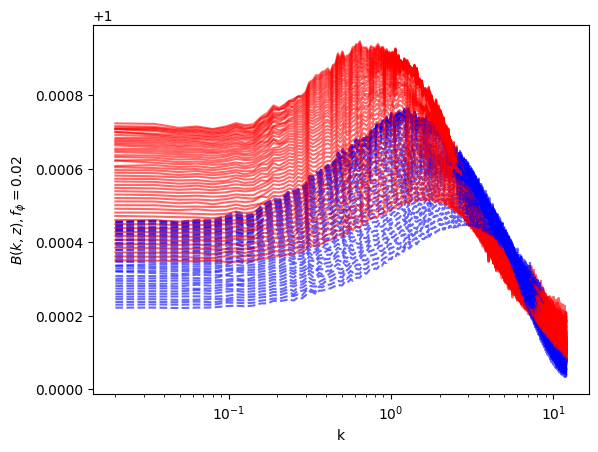

In [28]:
"""Plotting the Boost for the simulations at z = 0"""

for i in range(len(a_n[0])):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_0_tracker/pofk_my_new_Hi-COLA_simulation_0_tracker_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_0_tracker/pofk_my_new_Hi-COLA_simulation_0_tracker_phasepair_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_0_GR_tracker/pofk_my_new_Hi-COLA_simulation_0_GR_tracker_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_0_GR_tracker/pofk_my_new_Hi-COLA_simulation_0_GR_tracker_phasepair_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    
    Boost_plot = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp))
    plt.plot(k,Boost[24,i,:], "r", alpha=0.6)

    plt.plot(k,Boost_plot,"b--", alpha=0.6)
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z), f_{\phi} =0.02$")

Text(0, 0.5, '$B(k, z=0)$')

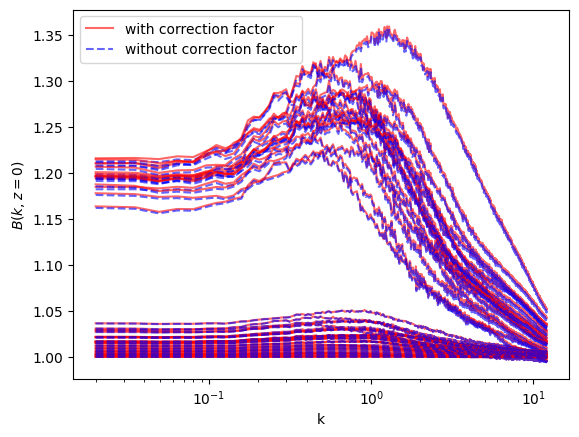

In [29]:
"""Plotting the Boost for the simulations at z = 0"""

for i in range(len(a_n[0])):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    Boost_plot = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp))
    plt.plot(k,Boost[i,0,:], "r", alpha=0.6)

    plt.plot(k,Boost_plot,"b--", alpha=0.6)
plt.xscale("log")
plt.xlabel("k")
plt.legend(["with correction factor", "without correction factor"])
plt.ylabel("$B(k, z=0)$")





Text(0, 0.5, '$B(k, z=0)$')

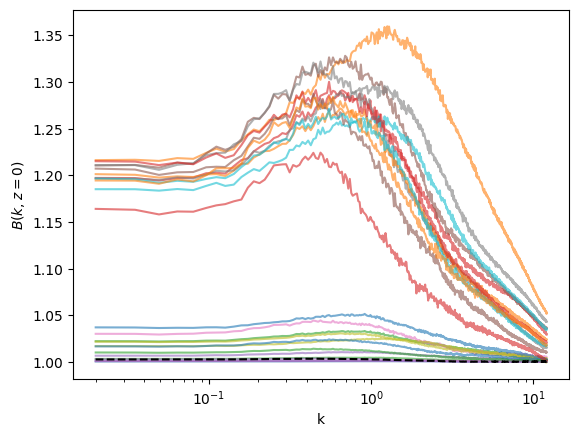

In [30]:
"""Plotting the Boost for the simulations at z = 0 (to compare with cell above)"""

for i in range(25):
    plt.plot(k,Boost[i,0,:], alpha=0.6)

plt.plot(k,Boost[14,0,:], "k--")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z=0)$")

Text(0, 0.5, '$B(k=0.02 $ h/Mpc $, z)$')

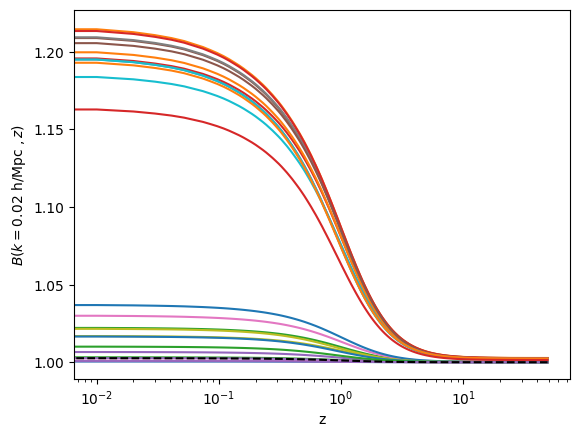

In [31]:
"""Plotting the Boost for the simulations at different z"""

for i in range(25):
    plt.plot(z,Boost[i,:,0])

plt.plot(z,Boost[14,:,0], "k--")
plt.xscale("log")
plt.xlabel("z")
plt.ylabel("$B(k=0.02 $ h/Mpc $, z)$")

In [32]:
"""Saving z and k"""

df_zk = pd.DataFrame([z,list(k)]).T
df_zk.columns = ["# z", "k (h/Mpc)"]
#export DataFrame to text file
with open(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k_validation_edges.txt', 'w') as f:
    df_string = df_zk.to_string(header=True, index=False)
    f.write(df_string)

In [33]:
"""Saving the Boost to a binary .npy file
Create a file B(sample point,k,z)"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_validation_edges.npy', Boost)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_validation_edges.npy')
print(arr_loaded.shape)

(50, 101, 768)


### Getting the Linear Boost (not essential for paper)

In [14]:
"""By the end of this cell, will have 
Boost = Boost(simulation, z, k)  --- WITH GROWTH FACTOR NORMALIZATION INCLUDED!
k = wavevector
z = redshift"""

Boost_Lin = np.zeros((len(a_n[0]),101,768))

for i in range(len(a_n[0])):

    # CG, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_Lin = [Pk_Lin_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin = np.append(Pk_Lin, [Pk_Lin_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin = Pk_Lin[z.argsort()]

    # CG, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_Lin_pp = [Pk_Lin_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin_pp = np.append(Pk_Lin_pp, [Pk_Lin_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin_pp = Pk_Lin_pp[z.argsort()]
    
    # GR, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_Lin_GR = [Pk_Lin_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin_GR = np.append(Pk_Lin_GR, [Pk_Lin_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin_GR = Pk_Lin_GR[z.argsort()]

    # GR, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend_validation_edges/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_Lin_GR_pp = [Pk_Lin_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin_GR_pp = np.append(Pk_Lin_GR_pp, [Pk_Lin_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin_GR_pp = Pk_Lin_GR_pp[z.argsort()]

    Boost_Lin[i] = ((Pk_Lin+ Pk_Lin_pp)/(Pk_Lin_GR + Pk_Lin_GR_pp)) * np.array(ratio_growth_new).T[np.argmin(np.abs(a_today - 0.02))][i]**2

z = sorted(z)

In [15]:
"""Saving the Boost to a binary .npy file
Create a file B(sample point,k,z)"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_Lin_validation_edges.npy', Boost_Lin)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_Lin_validation_edges.npy')
print(arr_loaded.shape)

(50, 101, 768)


In [ ]:
"""Plotting the Boost for the simulations at z = 0"""
Boost = np.load("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_validation_edges.npy")
Boost_Lin = np.load("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_Lin_validation_edges.npy")

zk_val = np.loadtxt(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k_validation_edges.txt') 
z_val = zk_val.T[0][~np.isnan(zk_val.T[0])]
k_val = zk_val.T[1]
print(len(Boost))
for i in range(50):
    plt.plot(k_val,Boost[i,0,:], "k", alpha=0.6)
    plt.plot(k_val,Boost_Lin[i,0,:], "r", alpha=0.6)

plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z=0)$")





50


Text(0, 0.5, '$B(k, z=0)$')

# Analyse P(k) from files

In [52]:
# Load hypercube

# We have Omega_m , n_s    , A_s  ,   E_ds   ,     f_phi

hypercube = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker')


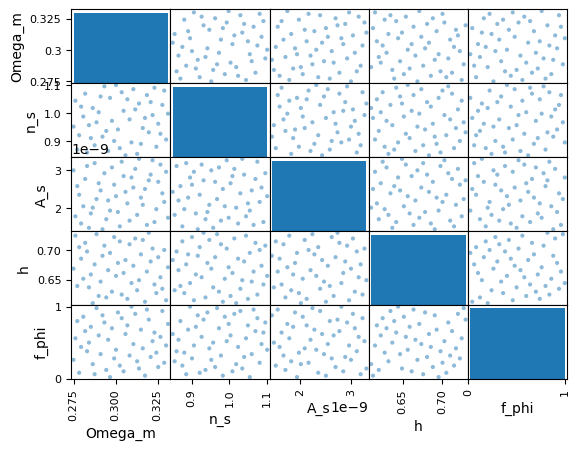

In [53]:
df_theta = pd.DataFrame(hypercube, columns=['Omega_m','n_s', 'A_s', 'h', 'f_phi'][:len(hypercube)])
pd.plotting.scatter_matrix(df_theta)
plt.show()
#print(df_theta['f_phi'])

In [54]:
# Load boost
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)


(50, 51, 768)


In [55]:
zk = np.loadtxt(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt') 
z = zk.T[0][~np.isnan(zk.T[0])]
k = zk.T[1]
print(z.shape)
print(k.shape)

(51,)
(768,)


37
14
0.980008
1.0


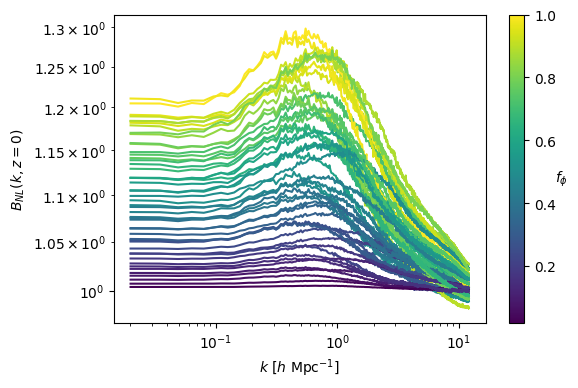

In [89]:
"""Plotting the NL power spectra for the simulations at z = 0"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['viridis']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = hypercube.T[4]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
print(hypercube.T[4][38])
print(hypercube.T[4][14])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0)

for i in range(len(arr_loaded)):
        plt.plot(k,arr_loaded[i,0,:], color = cmap(frac0[i]), label="z = 0")


ax.set_ylabel("$B_{NL}(k, z=0)$")

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.show()

NameError: name 'z' is not defined

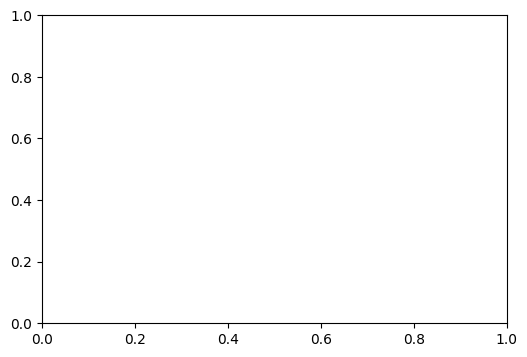

In [126]:
"""Plotting the NL power spectra for the simulations at all z for smallest f_phi"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['cool']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = z[:find_idxnearest(z, 1)]
print("z= ", z[:find_idxnearest(z, 1)])
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$z$', rotation=0)

for i in range(len(arr_loaded[0][:find_idxnearest(z, 1)])):
        plt.plot(k,arr_loaded[find_idxnearest(hypercube.T[4], 0),i,:], color = cmap(frac0[i]), label="z = 0")

for i in range(len(arr_loaded[0][find_idxnearest(z, 1):])):
        plt.plot(k,arr_loaded[find_idxnearest(hypercube.T[4], 0),i+ find_idxnearest(z, 1),:], "k--", label="z = 0", alpha=0.5)

print(hypercube.T[4][find_idxnearest(hypercube.T[4], 0)])

ax.set_ylabel("$B_{}(k, z), f_{} = ${}".format('{NL}','\phi', hypercube.T[4][find_idxnearest(hypercube.T[4], 0)]))

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.show()

NameError: name 'z' is not defined

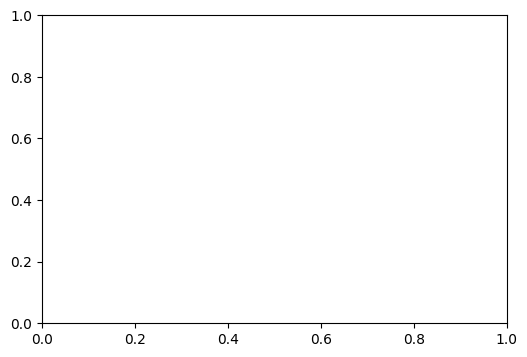

In [127]:
"""Plotting the NL power spectra for the simulations at all z for smallest f_phi"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['cool']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = z
#print("z= ", z)
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$z$', rotation=0)

for i in range(len(arr_loaded[0])):
        plt.plot(k,arr_loaded[find_idxnearest(hypercube.T[4], 0),i,:], color = cmap(frac0[i]), label="z = 0", alpha=0.3)
print(hypercube.T[4][find_idxnearest(hypercube.T[4], 0)])

ax.set_ylabel("$B_{}(k, z), f_{} = ${}".format('{NL}','\phi', hypercube.T[4][find_idxnearest(hypercube.T[4], 0)]))

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.show()

# Modify the boost

In [283]:
# Load boost
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)


(50, 51, 768)


In [284]:
zk = np.loadtxt(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt') 
z = zk.T[0][~np.isnan(zk.T[0])]
k = zk.T[1]
print(z.shape)
print(k.shape)

(51,)
(768,)


In [ ]:
new_boost = ratio_growth2 * boost

In [15]:
"""Saving the Boost
Create a file B_i(k,z) for each of the 50 points i, one file for each z"""

for i in range(51):
    col = ["# B_0(k)"]
    for j in range(49):
        col = np.append(col, "B_{}(k)".format(j+1))
    df = pd.DataFrame(Boost[:,i,:].T, columns= col)

    #specify path for export
    path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_z{}.txt'.format(z[i])
    
    #export DataFrame to text file
    with open(path, 'a') as f:
        df_string = df.to_string(header=True, index=False)
        f.write(df_string)

In [17]:
"""Save to zip file"""
zip = zipfile.ZipFile("Boost.zip", "w", zipfile.ZIP_DEFLATED)
for i in range(51):
    # NOTE: move the Packaged_output folder
    path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_z{}.txt'.format(z[i])
    zip.write(path,basename(path))
zip.close()

In [19]:
"""Saving z and k"""

df_zk = pd.DataFrame([z,list(k)]).T
df_zk.columns = ["# z", "k (h/Mpc)"]
#export DataFrame to text file
with open(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt', 'w') as f:
    df_string = df_zk.to_string(header=True, index=False)
    f.write(df_string)

In [18]:
"""Saving the Boost to a binary .npy file
Create a file B(sample point,k,z)"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy', Boost)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)

(50, 51, 768)
